# **DSI206 Project : Kaggle**

Compete in a Kaggle competition **[Yelp Restaurant Photo Classification](https://www.kaggle.com/competitions/yelp-restaurant-photo-classification)**, predict attribute labels for restaurants using user-submitted photos and submit our solution to the system.

Labels
-
* 0: good_for_lunch 
* 1: good_for_dinner 
* 2: takes_reservations 
* 3: outdoor_seating 
* 4: restaurant_is_expensive 
* 5: has_alcohol 
* 6: has_table_service 
* 7: ambience_is_classy 
* 8: good_for_kids

Brief Summary
-
Prepared our data in the Data Preparation part and train it on a VGGNet model to extract the image's feature vector in the Feature Extraction part and top it off by using a Random Forest and KNN model as our classification model to predict the labels and submit both models to see which performed better with the unseen data - That will be our final result.

Project path way
-
* Data Preparation
* Feature Extraction
* Classification

References
-
1. [VGG Very Deep Convolutional Networks (VGGNet) – What you need to know](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/)
2. [Transfer learning using VGG-16 with Deep Convolutional Neural Network for Classifying Images](https://www.ijsrp.org/research-paper-1019/ijsrp-p9420.pdf)
3. [Encoding Categorical Features with MultiLabelBinarizer](https://www.kdnuggets.com/2023/01/encoding-categorical-features-multilabelbinarizer.html)
4. [Random Forest Classifier Tutorial: How to Use Tree-Based Algorithms for Machine Learning](https://www.freecodecamp.org/news/how-to-use-the-tree-based-algorithm-for-machine-learning/)
5. [K-Nearest Neighbor(KNN) Algorithm for Machine Learning](https://www.javatpoint.com/k-nearest-neighbor-algorithm-for-machine-learning)

Members
-
* 6524651038 ปุณณวิช ศิลปเสริฐ
* 6524651244 ณิชพน รัถยาบัณฑิต
* 6524651376 นางสาวลภัสรดา ตรึกตรองกิจ
* 6524651400 นายวสันต์ อารัมภ์สกุล
* 6524651418 นางสาวศรินภัสร์ ศุภลักษณ์เมธา

In [1]:
# Required Libraries

import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import os 

# Feature Extraction
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16

# Data Preparation & Evalutaion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
from sklearn.multioutput import MultiOutputClassifier

# Classification Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Visualization
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Extract files
start_time = time.time()

!tar -xzf /kaggle/input/yelp-restaurant-photo-classification/sample_submission.csv.tgz
!tar -xzf /kaggle/input/yelp-restaurant-photo-classification/test_photo_to_biz.csv.tgz
!tar -xzf /kaggle/input/yelp-restaurant-photo-classification/test_photos.tgz
!tar -xzf /kaggle/input/yelp-restaurant-photo-classification/train.csv.tgz
!tar -xzf /kaggle/input/yelp-restaurant-photo-classification/train_photo_to_biz_ids.csv.tgz
!tar -xzf /kaggle/input/yelp-restaurant-photo-classification/train_photos.tgz

end_time = time.time()
print("Run time: {:.2f} seconds".format(end_time - start_time))
print("Run time: {:.2f} minutes".format((end_time - start_time)/60))

Run time: 286.34 seconds
Run time: 4.77 minutes


## Data Preparation

In [3]:
# Verify images in folder "train_photos" and collect validated images in "valid" for furthur usage
valid = []
for dirname, _, filenames in os.walk('/kaggle/working/train_photos'):
    for filename in filenames:
        if filename.startswith("."):
            pass
        else: valid.append(filename)
            
label_dict = {
    0: 'good_for_lunch',
    1: 'good_for_dinner',
    2: 'takes_reservations',
    3: 'outdoor_seating',
    4: 'restaurant_is_expensive',
    5: 'has_alcohol',
    6: 'has_table_service',
    7: 'ambience_is_classy',
    8: 'good_for_kids'
}

t = """
0: good_for_lunch
1: good_for_dinner
2: takes_reservations
3: outdoor_seating
4: restaurant_is_expensive
5: has_alcohol
6: has_table_service
7: ambience_is_classy
8: good_for_kids
"""

# Extract business attribute from "t" to "class_labels" e.g. good_for_lunch, outdoor_seating
class_lab = [x.split(":")[1].strip() for x in t.split("\n") if x.strip()]
class_labels = class_lab

# Generate Meta data of y
meta_data = pd.DataFrame(list(label_dict.items()), columns=['labid', 'lab'])

biz2lab = pd.read_csv("train.csv") # business id & label 
img2biz = pd.read_csv("train_photo_to_biz_ids.csv") # photo_id & business id

# Feature engineering; create new column "lab", each sample contains list of string from "labels"
img2lab = img2biz.merge(biz2lab, on='business_id')
img2lab["lab"] = img2lab['labels'].str.split(" ")

# Get Image Function
def get_img(photo_id:str):
    '''
    input : photo_id (str)
    output : showing image
    
    Showing image in train photos folder given photo_id
    '''
    img_path = 'train_photos/' + str(photo_id) + '.jpg'
    img = image.load_img(img_path, target_size=(200, 200, 3))
    img = image.img_to_array(img)
    img = img / 255.0  
    
    return img

# Drop duplicates 
bizimg = img2lab.drop_duplicates(subset="business_id")[['business_id', 'lab']].reset_index(drop=True).copy()

# Prepare 5 new columns for inputing "photo_id" from each 5 images of each business_id;
for i in range(1, 6):
    bizimg[f'photo_{i}'] = np.nan

# For each business_id pick 5 images, then input "photo_id" of each image to the prepared columns.
for ind,row in bizimg.iterrows():
    try:
        mask = img2lab['business_id'] == row['business_id']
        photo_ids = img2lab.loc[mask, 'photo_id'].sample(n=5).values.tolist()
        for i in range(1, 6):
            bizimg.at[ind, f'photo_{i}'] =f"{photo_ids[i - 1]:.0f}"
    except Exception as e:print(e)
        
# Drop missing values
bizimg = bizimg.dropna().reset_index(drop=True)
display(bizimg)

Cannot take a larger sample than population when 'replace=False'
Cannot take a larger sample than population when 'replace=False'


,business_id,lab,photo_1,photo_2,photo_3,photo_4,photo_5
0,3034,"[3, 8]",449418,148939,77797,368234,3435
1,2805,"[1, 2, 3, 5, 6, 7]",26348,52779,295808,312193,250906
2,485,"[1, 2, 3, 4, 5, 6, 7]",200790,262094,404032,287087,80748
3,1783,"[1, 2, 3, 5, 6, 7]",436184,457133,435940,301584,97110
4,35,"[1, 2, 5, 6, 8]",436758,71338,46370,208311,361573
...,...,...,...,...,...,...,...
1989,1344,"[3, 8]",280252,135428,425499,134154,346482
1990,772,"[1, 2, 3, 4, 5, 6]",230134,39905,136127,311335,154769
1991,407,"[1, 2, 3, 4, 5, 6]",77208,121331,24199,166760,267125
1992,3150,"[1, 2, 3, 4, 5, 6]",272005,397363,230098,242319,142519


## Feature Extraction using VGGNet
We tried using Resnet50 as our first approach but it turned out that it's too much time-consuming. Instead, we found a different approach that is VGG-16 form VGGNet 

### VGGNet

VGG stands for Visual Geometry Group; it is a standard deep Convolutional Neural Network (CNN) architecture with multiple layers. The “deep” refers to the number of layers with VGG-16 or VGG-19 consisting of 16 and 19 convolutional layers.

#### VGG Architecture
VGGNets are based on the most essential features of convolutional neural networks (CNN). The following graphic shows the basic concept of how a CNN works:

![Image](https://viso.ai/wp-content/uploads/2021/10/how-vgg-works-convolutional-neural-network.jpg)

<span style="color:gray">The architecture of a Convolutional Neural Network: Image data is the input of the CNN; the model output provides prediction categories for input images</span>. - [Source](https://icmlviz.github.io/icmlviz2016/assets/papers/4.pdf)

The VGG network is constructed with very small convolutional filters. The VGG-16 consists of 13 convolutional layers and three fully connected layers.

* Input: The VGGNet takes in an image input size of 224×224. For the ImageNet competition, the creators of the model cropped out the center 224×224 patch in each image to keep the input size of the image consistent. 
* Convolutional Layers: VGG’s convolutional layers leverage a minimal receptive field, i.e., 3×3, the smallest possible size that still captures up/down and left/right. Moreover, there are also 1×1 convolution filters acting as a linear transformation of the input. This is followed by a ReLU unit, which is a huge innovation from AlexNet that reduces training time. ReLU stands for rectified linear unit activation function; it is a piecewise linear function that will output the input if positive; otherwise, the output is zero. The convolution stride is fixed at 1 pixel to keep the spatial resolution preserved after convolution (stride is the number of pixel shifts over the input matrix).
* Hidden Layers: All the hidden layers in the VGG network use ReLU. VGG does not usually leverage Local Response Normalization (LRN) as it increases memory consumption and training time. Moreover, it makes no improvements to overall accuracy.
* Fully-Connected Layers: The VGGNet has three fully connected layers. Out of the three layers, the first two have 4096 channels each, and the third has 1000 channels, 1 for each class.

### VGG16
The VGG model, or VGGNet, that supports 16 layers is also referred to as VGG16, which is a convolutional neural network model proposed by A. Zisserman and K. Simonyan from the University of Oxford. These researchers published their model in the research paper titled, “[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://icmlviz.github.io/icmlviz2016/assets/papers/4.pdf).”

#### VGG16 Architecture
The number 16 in the name VGG refers to the fact that it is 16 layers deep neural network (VGGnet). This means that VGG16 is a pretty extensive network and has a total of around 138 million parameters. Even according to modern standards, it is a huge network. However, VGGNet16 architecture’s simplicity is what makes the network more appealing. Just by looking at its architecture, it can be said that it is quite uniform. There are a few convolution layers followed by a pooling layer that reduces the height and the width. If we look at the number of filters that we can use, around 64 filters are available that we can double to about 128 and then to 256 filters. In the last layers, we can use 512 filters.

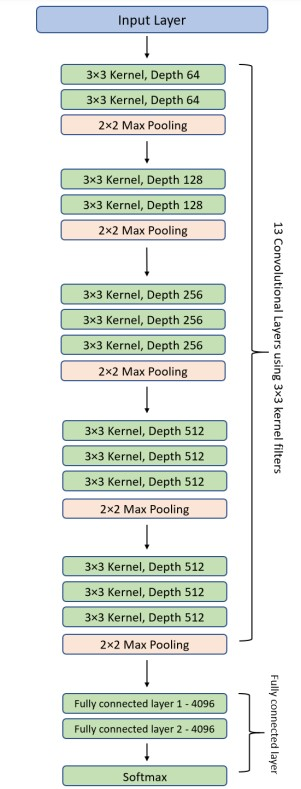

<span style="color:gray">VGG-16 Architecture of a VGG16 model</span>. - [source](https://www.ijsrp.org/research-paper-1019/ijsrp-p9420.pdf)

VGG networks have a simple architecture and can be effective for multi-class classification. They are relatively straightforward to implement and less time-consuming compared to other models. With that, VGG-16 with pre-trained weights will be used for the Feature Extraction part. In other word, we are just going to use only the 13 Convolutional Layers of VGG-16

### Transfer Learning
Pre-trained models leverage knowledge gained from large datasets during their initial training. This knowledge includes general features and representations that are useful for a wide range of tasks. When you use a pre-trained model as a starting point, you're essentially benefiting from the learning that has already taken place, saving time and computational resources.

Instead of training the model from scratch, you can use pre-trained models as feature extractors. The early layers of the network, which capture low-level features and patterns, can be frozen, and only the final layers are fine-tuned on your specific task. This approach is faster than training the entire model. Thus, will help a lot to our solution.

### Pretrained Convolutional neural network model as a feature extractor with image augmentation
– Here we will implement VGG-16 pretrained model which is trained on the imagenet weights to extract features and feed this output to new classifier to classify images.

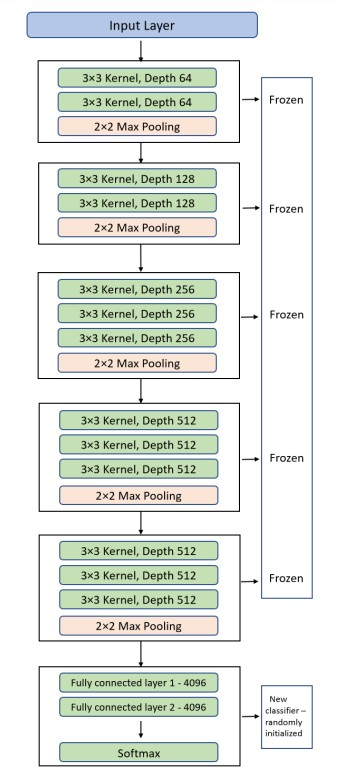

<span style="color:gray">Block diagram shows the architecture of VGG-16. To extract feature vectors from VGG-16 model, weights of all 5 convolutional blocks are frozen </span> <span style="color:gray">and resulted output is given to new classifier.</span> - [source](https://www.ijsrp.org/research-paper-1019/ijsrp-p9420.pdf)

In [4]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Create a model that includes only the convolutional layers
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract Feature !!
def extract_features(photo_id:str):
    '''
    input : photo_id(str)
    output : vector feature of feature (array)
    
    Extract feature from image using VGG16 CNN Architecture
    '''
    image_path = 'train_photos/' + str(photo_id) + '.jpg'
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array,verbose=0)
    return features.flatten()

58889256/58889256 [==============================] - 0s 0us/step


Above is the code to call VGG-16 pretrained model. We need to include weights = ‘imagenet’ to fetch VGG-16 model which is trained on the imagenet dataset. It is important to set include_top = False to avoid downloading the fully connected layers of the pretrained model.

In [5]:
# Extract Feature vectors (X) and get Labels (y) to train classification model

start_time = time.time()

X = []
y = []

for i in tqdm(range(len(bizimg)), "Getting Feature"):
    label = bizimg.iloc[i, 1]
    feature_1 = extract_features(bizimg.iloc[i, 2])
    feature_2 = extract_features(bizimg.iloc[i, 3])
    feature_3 = extract_features(bizimg.iloc[i, 4])
    feature_4 = extract_features(bizimg.iloc[i, 5])
    feature_5 = extract_features(bizimg.iloc[i, 6])
    
    X.extend([feature_1, feature_2, feature_3, feature_4, feature_5])
    y.extend([label]*5)  # Repeat the label for each feature
    
end_time = time.time()
print("Run time: {:.2f} seconds".format(end_time - start_time))
print("Run time: {:.2f} minutes".format((end_time - start_time)/60))

Getting Feature: 100%|██████████| 1994/1994 [09:40<00:00,  3.43it/s]

Run time: 580.73 seconds
Run time: 9.68 minutes


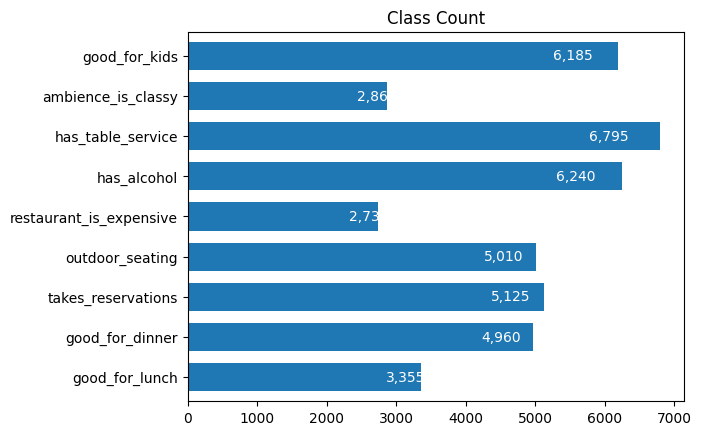

In [6]:
# Each class's amount of apperances
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(y)
y_bin_df = pd.DataFrame(y_binary)

class_count = y_bin_df.sum(axis=0)
class_count.index = class_count.index.map(label_dict)

class_count.plot(kind='barh',width = 0.7)
plt.title("Class Count")
for i, val in enumerate(class_count):
    pos_x = val * 0.85
    plt.text(pos_x, i, f"{val:,.0f}", va='center', color='white')
plt.show()

## **Classification**
Previously, we got a feature vectors from the Feature Extraction part and it's ready to be train. In this Classification part, we'll keep it simple by using two popular classifiers, **Random Forest Classifier** and **KNN** (K-Nearest Neighbors Algorithm) to predict the outcomes and compare to see which model performed better in this task.

In [7]:
# Feature vectors sample size
print(f"Sample size: {len(X)}")

Sample size: 9970


In [8]:
# Split data train:test = 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert y_train and y_test to a binary matrix using MultiLabelBinarizer encoding 
mlb = MultiLabelBinarizer()
y_train_binary = mlb.fit_transform(y_train)
y_test_binary = mlb.transform(y_test)

#### One-hot encoding
– is a technique used in machine learning and data preprocessing to represent categorical variables as binary vectors, in a format suitable for machine learning models. It is particularly useful when dealing with categorical features in a dataset. The process involves converting categorical values into a binary matrix, where each category is represented by a unique column, and the presence or absence of a category is indicated by a binary value (1 or 0).

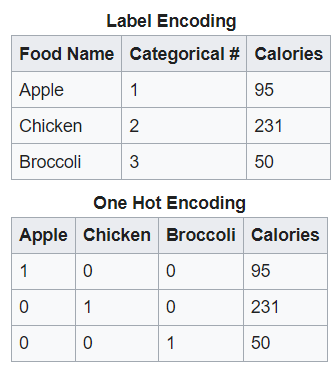

One-hot encoding works with data that have only one label per sample. In this project we need to deal with samples with multiple labels. Instead, we use MultiLabelBinarizer

#### MultiLabelBinarizer
– converts iterable of iterables and multilabel targets into binary encoding which is transforming multiple labels into a binary matrix representation. It is particularly useful when dealing with multi-label classification problems.

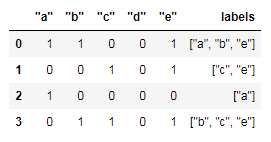

In [9]:
pd.DataFrame(y_train_binary, columns=mlb.classes_)

,0,1,2,3,4,5,6,7,8
0,1,0,0,0,0,0,1,0,1
1,0,1,1,1,1,1,1,1,0
2,0,1,1,1,1,1,1,1,0
3,0,1,0,0,0,1,1,0,1
4,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
7971,1,0,0,1,0,0,1,0,1
7972,1,0,0,0,0,0,0,0,1
7973,1,1,0,1,0,1,0,0,0
7974,0,1,0,0,1,1,1,0,1


### **1. Random Forest Classifier**
The Random Forest Classifier is an ensemble learning algorithm that leverages the power of decision trees to achieve robust and accurate predictions. It constructs a multitude of decision trees during training, each trained on a different subset of the dataset using bootstrapped sampling. To introduce diversity among the trees and prevent overfitting, the algorithm randomly selects a subset of features at each split node. During prediction, the individual trees "vote" for a class in classification tasks, and the class with the majority of votes becomes the final prediction.

#### The random forest algorithm works by completing the following steps:
1. The algorithm select random samples from the dataset provided.
2. The algorithm will create a decision tree for each sample selected. Then it will get a prediction result from each decision tree created.
3. Voting will then be performed for every predicted result. For a classification problem, it will use mode, and for a regression problem, it will use mean.
4. And finally, the algorithm will select the most voted prediction result as the final prediction.

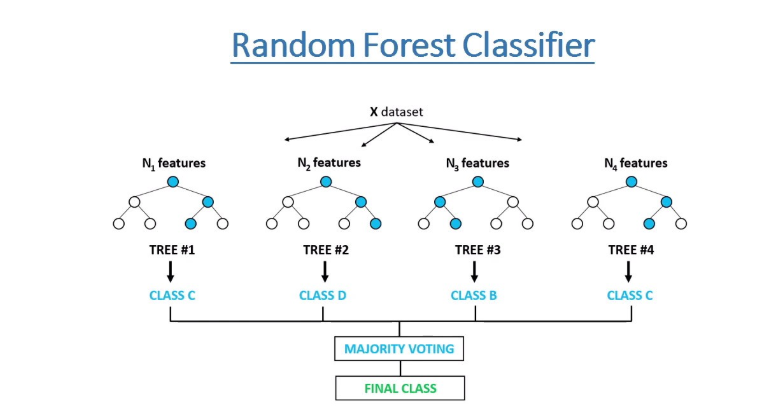

<span style="color:gray"> how Random Forest Classifier works </span> - [source](https://www.freecodecamp.org/news/how-to-use-the-tree-based-algorithm-for-machine-learning/)

In [10]:
# Random Forest Classifier
param_grid = {
    'n_estimators': [200],
    'max_depth': [20]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=2, scoring = make_scorer(f1_score, average='weighted'), verbose=2)
grid_search.fit(X_train, y_train_binary)

best_params = grid_search.best_params_
best_model_rdf = grid_search.best_estimator_

y_pred_binary = best_model_rdf.predict(X_test)

accuracy = accuracy_score(y_test_binary, y_pred_binary)
classification_report_output = classification_report(y_test_binary, y_pred_binary)

print("Best Parameters:", best_params)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END .....................max_depth=20, n_estimators=200; total time= 3.9min
[CV] END .....................max_depth=20, n_estimators=200; total time= 3.9min
Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Accuracy: 0.04
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.04      0.07       651
           1       0.64      0.57      0.60       986
           2       0.62      0.65      0.63      1014
           3       0.54      0.51      0.53      1018
           4       0.66      0.10      0.17       548
           5       0.64      0.95      0.77      1246
           6       0.69      0.99      0.81      1367
           7       0.63      0.08      0.15       564
           8       0.67      0.94      0.78      1233

   micro avg       0.64      0.64      0.64      8627
   macro avg       0.64      0.54      0.50      8627
weighted avg       0.64      0.64  

Above is the code to train Random Forest Classifier. We set the list of Hyperparameter "n_estimator"(number of trees) to 200 and "max_depth"(tree's depth) to 20 which has the highest score among other set of parameters.

### **2. KNN**
K-Nearest Neighbors (KNN) is a simple and intuitive machine learning algorithm used for both classification and regression tasks. It belongs to the family of instance-based or lazy learning algorithms. Instead of learning a model during the training phase, KNN classifies or predicts new data points based on the similarity to the training data.

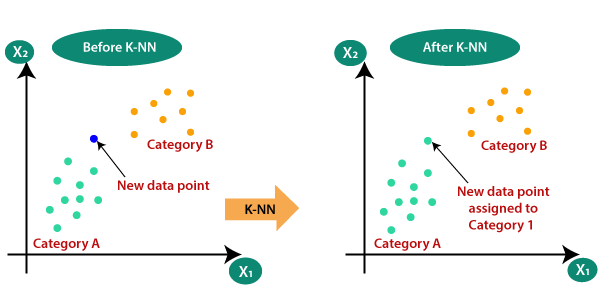

<span style="color:gray"> how KNN works </span> - [source](https://www.javatpoint.com/k-nearest-neighbor-algorithm-for-machine-learning)

#### The K-NN working can be explained on the basis of the below algorithm:
1. Select the number K of the neighbors
2. Calculate the Euclidean distance of K number of neighbors
3. Take the K nearest neighbors as per the calculated Euclidean distance.
4. Among these k neighbors, count the number of the data points in each category.
5. Assign the new data points to that category for which the number of the neighbor is maximum.
6. Our model is ready.

$$\text{distance} = \sqrt{\sum_{i=1}^d (\text{x}_\text{new,i} - \text{x}_{\text{train,i}})^2}$$

While KNN is typically designed for single-label tasks, where each instance belongs to a single class or has a single target value. However, KNN can be adapted for multi-label tasks too.

#### How KNN algorithm works in a multilabel problem?
– One of the approachs is to use Multi-Output KNN or to use MultiOutputClassifier() with KNeighborsClassifier() that provide a multi-output version of KNN, where the algorithm considers multiple labels simultaneously during training and prediction. This allows the model to capture dependencies between labels. It is show in the code below:

In [11]:
# K-Nearest Neighbors
param_grid_knn = {'estimator__n_neighbors': [8,9,10],
                  'estimator__weights': ['distance'],
                 'estimator__metric': ['euclidean', 'cosine']}

base_knn_model = KNeighborsClassifier()

knn_model = MultiOutputClassifier(base_knn_model)

grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=2,
                                scoring=make_scorer(f1_score, average='weighted'), verbose=2)

grid_search_knn.fit(X_train, y_train_binary)

best_params_knn = grid_search_knn.best_params_
best_model_knn = grid_search_knn.best_estimator_

y_pred_knn = best_model_knn.predict(X_test)

f1_knn = f1_score(y_test_binary, y_pred_knn, average='weighted')
accuracy_knn = accuracy_score(y_test_binary, y_pred_knn)

# Print the results
print("Best parameters for KNN:", best_params_knn)
print("Macro-average F1 Score (KNN):", f1_knn)
print("Accuracy (KNN):", accuracy_knn)

report  = classification_report(y_test_binary, y_pred_knn)
print(report)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END estimator__metric=euclidean, estimator__n_neighbors=8, estimator__weights=distance; total time= 1.6min
[CV] END estimator__metric=euclidean, estimator__n_neighbors=8, estimator__weights=distance; total time= 1.6min
[CV] END estimator__metric=euclidean, estimator__n_neighbors=9, estimator__weights=distance; total time= 1.6min
[CV] END estimator__metric=euclidean, estimator__n_neighbors=9, estimator__weights=distance; total time= 1.6min
[CV] END estimator__metric=euclidean, estimator__n_neighbors=10, estimator__weights=distance; total time= 1.6min
[CV] END estimator__metric=euclidean, estimator__n_neighbors=10, estimator__weights=distance; total time= 1.5min
[CV] END estimator__metric=cosine, estimator__n_neighbors=8, estimator__weights=distance; total time=  39.6s
[CV] END estimator__metric=cosine, estimator__n_neighbors=8, estimator__weights=distance; total time=  39.3s
[CV] END estimator__metric=cosine, estimator__n_

Above is the code to train KNN. We set the list of Hyperparameter "estimator__n_neighbors"(number of neighbors) to [8,9,10], "estimator__weights"(weight function) to ['distance'] and "estimator__metric"(distance metrics) to ['euclidean', 'cosine'] and let grid_search_knn.best_params_ find the best parameter. The same goes for grid_search_knn.best_estimator_ to find the best KNN model and get the most score out of it.

## **Submit to competition**

In [12]:
test_df = pd.read_csv("test_photo_to_biz.csv")
test_df = test_df.drop_duplicates(subset='business_id', keep='first').reset_index(drop=True)

In [13]:
def extract_test_features(photo_id:str):
    '''
    input : photo_id(str)
    output : vector feature of feature (array)
    
    Extract feature from image using VGG16 CNN Architecture
    '''
    image_path = 'test_photos/' + str(photo_id) + '.jpg'
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array,verbose=0)
    return features.flatten()

In [14]:
# Extract test image feature
test_biz = []
test_X = []
for ind,row in tqdm(test_df.iterrows(), "Extract Feature"):
    photo_id = row['photo_id']
    test_X.append(extract_test_features(photo_id))
    test_biz.append(row['business_id'])

Extract Feature: 10000it [10:53, 15.30it/s]


In [15]:
# Random Forest
test_pred = best_model_rdf.predict(test_X)
real_pred = [' '.join(x) for x in mlb.inverse_transform(test_pred)]
submiss = pd.DataFrame(data = [test_biz, real_pred]).T
submiss.columns = ['business_id', 'labels']
submiss.to_csv("submission_rdf.csv", index=False)

In [16]:
# K-Nearest Neighbors
test_pred = best_model_knn.predict(test_X)
real_pred = [' '.join(x) for x in mlb.inverse_transform(test_pred)]
submiss = pd.DataFrame(data = [test_biz, real_pred]).T
submiss.columns = ['business_id', 'labels']
submiss.to_csv("submission_knn.csv", index=False)

#### Thanks for reading.